# Analysis of Ariane Qualitative Runs

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt, animation
import xarray as xr
import numpy as np
import pandas as pd
import cmocean as cm
from datetime import datetime
from IPython.display import HTML
import netCDF4 as nc
from cartopy import crs, feature

## test run with SalishSeaCast

In [2]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
file = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/salish_qual/forward_01mar19/ariane_trajectories_qualitative.nc')

Text(0, 0.5, 'lat')

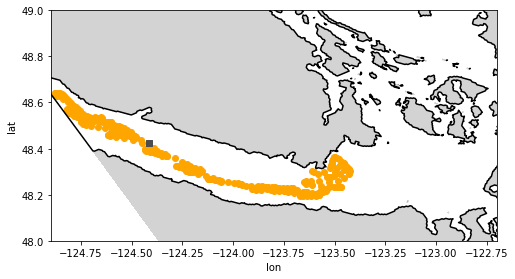

In [3]:
# 2D
fig, ax = plt.subplots(1,1,figsize=(8,4.6))

ax.contourf(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124.9, -122.7])
ax.set_ylim([48, 49])
ax.set_aspect(5/4.4)

ax.scatter(file.traj_lon,file.traj_lat,color='orange')
ax.scatter(file.traj_lon[0],file.traj_lat[0],color='0.30',marker='s')

ax.set_xlabel('lon')
ax.set_ylabel('lat')

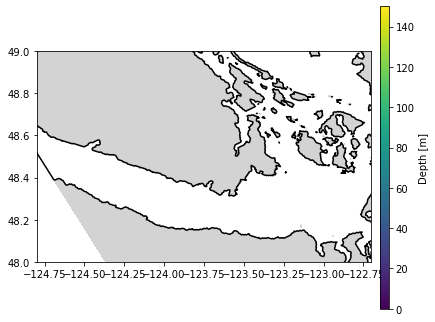

In [4]:
# Make initial animation figure
fig, ax = plt.subplots(figsize=(6, 6))
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
l = ax.scatter([], [], s=50, c=[], vmin=0, vmax=150, edgecolor='k')
t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
ax.contourf(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124.8, -122.7])
ax.set_ylim([48, 49])
ax.set_aspect(1/np.sin(np.deg2rad(49)))
fig.colorbar(l, cax=cax, label='Depth [m]')

# Init function
def init():
    t.set_text('')
    l.set_offsets(np.empty((0, 2)))
    l.set_array(np.empty(0))
    return l, t,

# Animate function
def animate(hour):
    l.set_offsets(np.vstack([file.traj_lon[hour,:], file.traj_lat[hour,:]]).T)
    l.set_array(file.traj_depth[hour,:])
    return l,t ,

# Build animation
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(file.nb_output)-1, interval=100, blit=True)

In [5]:
HTML(anim.to_html5_video())

## CIOPS BC12
#### first: lets make some smart choices about where to put the particles!

In [3]:
# date = datetime(2016,1,1)
# nc_file = "/ocean/rbeutel/data/{:%Y%m}/U_new_{:%Y%m%d}.nc".format(date,date)
nc_file = "/ocean/rbeutel/data/201701/U_new_20170101.nc"
nc_to_plot = xr.open_dataset(nc_file)
mesh = xr.open_dataset('/ocean/mdunphy/CIOPSW-BC12/grid/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc')

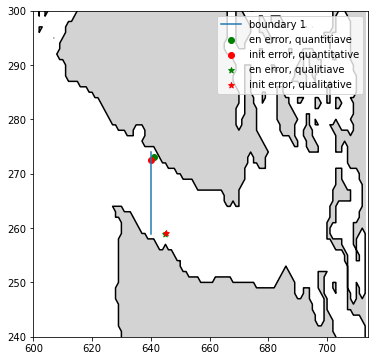

In [4]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.contourf(mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim(600, 714)
# ax.set_ylim(200,400)
ax.set_ylim(240,300)
ax.plot([640,640], [259,274], label='boundary 1')
ax.scatter(641, 273, c='g', label='en error, quantitiave')
ax.scatter(640, 272.5, c='r', label='init error, quantitative')
ax.scatter(645, 259, c='g', marker = '*', label='en error, qualitiave')
ax.scatter(645.01, 259.01, c='r', marker="*", label='init error, qualitative')
ax.legend()

Text(0.5, 1.0, 'Depth = 70')

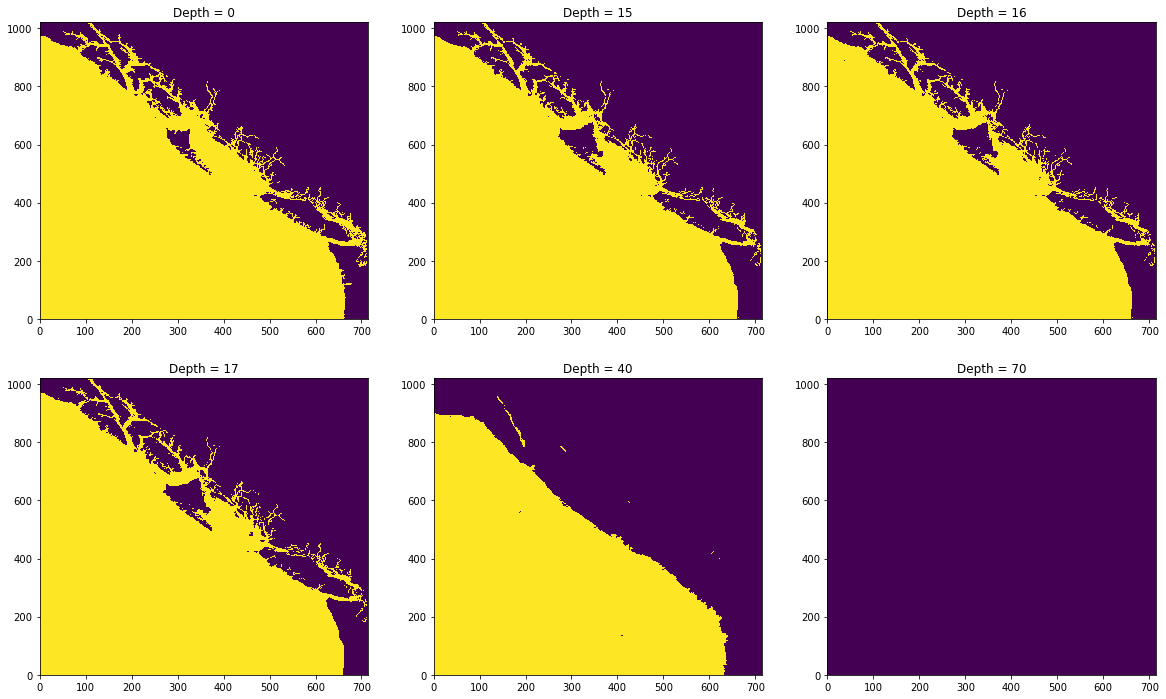

In [5]:
#lets plot the whole tmask domain
# depths = np.arange(0,20,1)
d = [0, 15, 16, 17, 40, 70]
fig, ax = plt.subplots(nrows=2,ncols=3, figsize=(20,12))

ax[0,0].pcolormesh(mesh.tmask[0,d[0],:,:])
ax[0,0].set_title("Depth = " + str(d[0]))
ax[0,1].pcolormesh(mesh.tmask[0,d[1],:,:])
ax[0,1].set_title("Depth = " + str(d[1]))
ax[0,2].pcolormesh(mesh.tmask[0,d[2],:,:])
ax[0,2].set_title("Depth = " + str(d[2]))

ax[1,0].pcolormesh(mesh.tmask[0,d[0+3],:,:])
ax[1,0].set_title('Depth = '+ str(d[3]))
ax[1,1].pcolormesh(mesh.tmask[0,d[1+3],:,:])
ax[1,1].set_title('Depth = '+ str(d[4]))
ax[1,2].pcolormesh(mesh.tmask[0,d[2+3],:,:])
ax[1,2].set_title('Depth = '+ str(d[5]))
# this is where it says the false start is occuring! but where the false start is (this x and y, depth=16) water exists!

### ^nothing overtly insane to me!

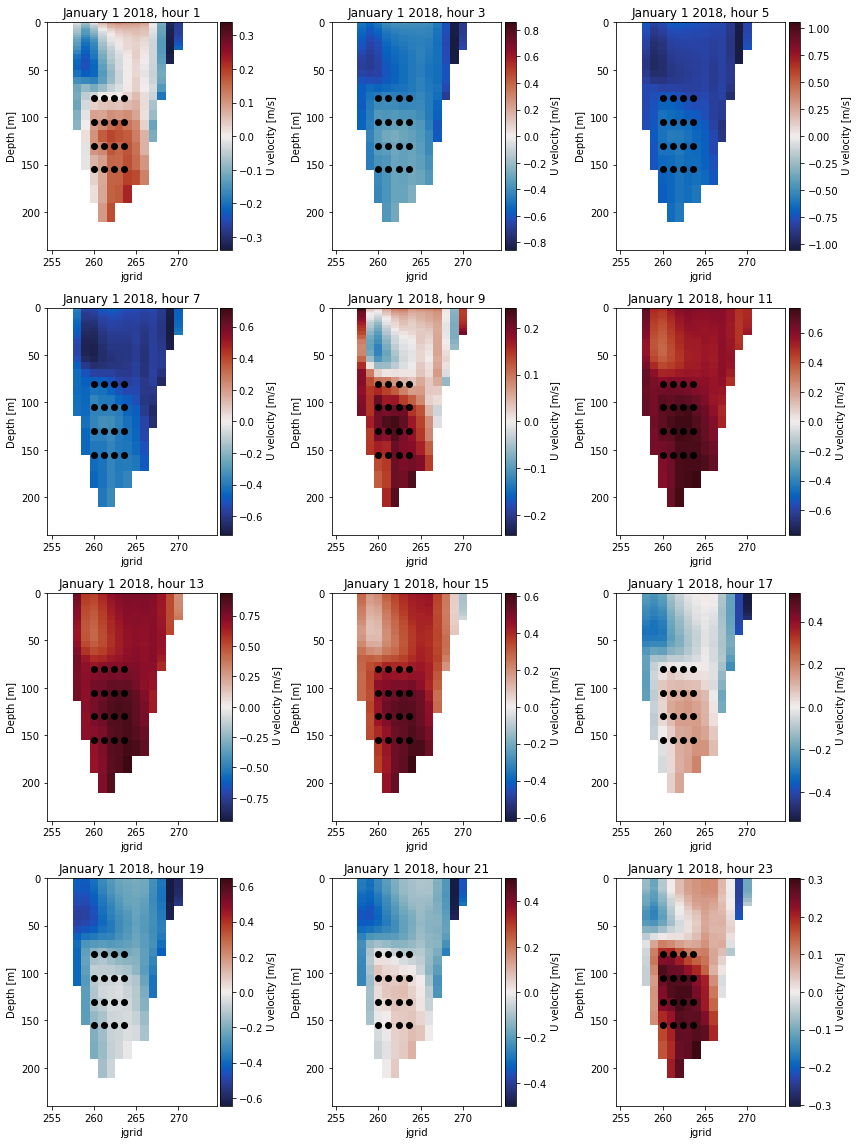

In [9]:
# nc_file = "/ocean/rbeutel/data/{:%Y%m}/U_new_{:%Y%m%d}.nc".format(date,date)
nc_to_plot = nc.Dataset(nc_file)
mesh_nc = nc.Dataset('/ocean/mdunphy/CIOPSW-BC12/grid/mesh_mask_Bathymetry_NEP36_714x1020_SRTM30v11_NOAA3sec_WCTSS_JdeFSalSea.nc')

# hours = [0, 3, 6, 12, 15, 18, 21, 24]
hours = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]

variable = 'vozocrtx'
fig, ax= plt.subplots(nrows=4, ncols=3, figsize =(12,16))

igrid = 646-1
latS = 255
latN = 275
k = 0

for hour in hours:
    data = nc_to_plot[variable][hour,:,latS:latN,igrid]
    # X, Y = np.meshgrid(nc_to_plot['nav_lat'][646,255:273], nc_to_plot['depthu'])
    section_slice = np.arange(latS,latN)
    zlevels = mesh_nc['gdept_1d'][:][0]
    X, Y = np.meshgrid(section_slice, zlevels)
    tmesh = ax[hour//6,k].pcolormesh(X,Y,data, cmap = cm.cm.balance, \
                          vmin = -1 * np.max(np.abs(data)), vmax = np.max(np.abs(data)))

    ax[hour//6,k].set_ylim([0,240])
    ax[hour//6,k].invert_yaxis()
    ax[hour//6,k].set_ylabel('Depth [m]')
    ax[hour//6,k].set_xlabel('jgrid')
    ax[hour//6,k].set_title('January 1 2018, hour '+str(hour+1))
    
    cbar = fig.colorbar(tmesh, ax=ax[hour//6,k], orientation = 'vertical',fraction=0.08, pad=0.02)#, ticks = tticks)
    cbar.set_label(label=' U velocity [m/s]') 
    
    # particle location evenly arangedthrough lower half of water column
#     ax[hour//6,k].scatter([260,260,260,262.3,262.3,262.3,262.3,264.7,264.7,264.7,264.7,267,267,267],[90,120,150, 90,120, 150, 180, 90,120, 150, 180,90, 120, 150],c='k')
    # particle location focused in area of high influx (from SSC JR CSs)
    ax[hour//6,k].scatter([260,260,260,260,261.2,261.2,261.2,261.2,262.4,262.4,262.4,262.4,263.6,263.6,263.6,263.6],[80,105,130,155,80,105,130,155,80,105,130,155,80,105,130,155],c='k')
    #once i get CIOPS to work i honestly think i should do both particle location schemes
    
    if k ==2:
        k = 0
    else:
        k +=1 
    
plt.tight_layout()

# ax[1].scatter([261,261,261,263.5,263.5,263.5,263.5,266,266,266],[90,120,150, 90,120, 150, 180, 90, 120, 150],c='k')

In [10]:
#now for ariane you cannot set the position at a depth of 90 bc that will put it incell 90 (which doesn't exist)
#instead find with depth grid cell that best corresponds with the positions you chose above
[(x,y) for (x,y) in enumerate(zlevels)]

[(0, 0.507530023512452),
 (1, 1.557569488842656),
 (2, 2.6693409194084996),
 (3, 3.857884935301262),
 (4, 5.141913831146915),
 (5, 6.544535333853228),
 (6, 8.093971465979628),
 (7, 9.824157673695284),
 (8, 11.775044353140647),
 (9, 13.992364711100425),
 (10, 16.52661505451083),
 (11, 19.43106879090391),
 (12, 22.758861118719427),
 (13, 26.559531476793033),
 (14, 30.875785062827266),
 (15, 35.74142752531527),
 (16, 41.181253706626364),
 (17, 47.21313511579986),
 (18, 53.85189559955382),
 (19, 61.11412039354691),
 (20, 69.02298960174267),
 (21, 77.61249605846115),
 (22, 86.93079063628434),
 (23, 97.04271072951805),
 (24, 108.03171341445899),
 (25, 120.0014691078047),
 (26, 133.0773268246376),
 (27, 147.4077864359136),
 (28, 163.16603544640805),
 (29, 180.55153922041305),
 (30, 199.79161550620404),
 (31, 221.14287374964496),
 (32, 244.8923539986389),
 (33, 271.3581577853082),
 (34, 300.8893252934304),
 (35, 333.8646831888884),
 (36, 370.6903722478645),
 (37, 411.79577220550027),
 (38, 457

SO 90 m=22, 120 m=25, 150 m=27, and 180 m=29

In [11]:
file = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_qual/forward_01mar17/ariane_trajectories_qualitative.nc')

Text(0, 0.5, 'lat')

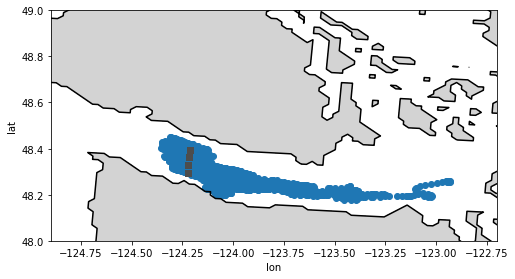

In [12]:
# 2D
fig, ax = plt.subplots(1,1,figsize=(8,4.6))

ax.contourf(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124.9, -122.7])
ax.set_ylim([48, 49])
ax.set_aspect(5/4.4)

ax.scatter(file.traj_lon,file.traj_lat)
ax.scatter(file.traj_lon[0],file.traj_lat[0],color='0.30',marker='s')

ax.set_xlabel('lon')
ax.set_ylabel('lat')

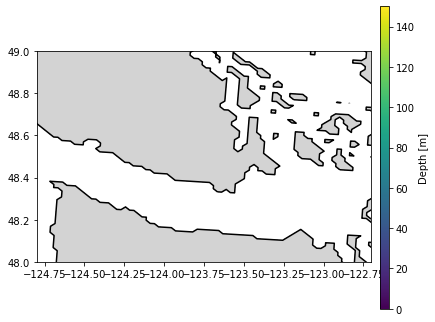

In [13]:
# Make initial animation figure
fig, ax = plt.subplots(figsize=(6, 6))
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
l = ax.scatter([], [], s=50, c=[], vmin=0, vmax=150, edgecolor='k')
t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
ax.contourf(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
ax.contour(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124.8, -122.7])
ax.set_ylim([48, 49])
ax.set_aspect(1/np.sin(np.deg2rad(49)))
fig.colorbar(l, cax=cax, label='Depth [m]')

# Init function
def init():
    t.set_text('')
    l.set_offsets(np.empty((0, 2)))
    l.set_array(np.empty(0))
    return l, t,

# Animate function
def animate(hour):
#     tstamp = file.traj_time[hour, 0].values.astype('datetime64[s]').astype(datetime)
#     t.set_text(tstamp.strftime('%Y-%b-%d %H:%M UTC'))
    l.set_offsets(np.vstack([file.traj_lon[hour,:], file.traj_lat[hour,:]]).T)
    l.set_array(file.traj_depth[hour,:])
    return l, t,

# Build animation
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(file.nb_output)-1, interval=100, blit=True)

In [14]:
HTML(anim.to_html5_video())

In [15]:
file.traj_depth[:,0]

<xarray.DataArray 'traj_depth' (nb_output: 241)>
array([-102.421585, -100.559929, -102.398514, ...,  -77.736279,  -75.82184 ,
        -76.703534])
Dimensions without coordinates: nb_output
Attributes:
    title:     What is traj_depth ?
    longname:  Trajectory: z positions
    units:     No dimension

### now with backwards!?

In [24]:
def plt_qual_2D(month, ax):
    
    if month == 'feb':
        file = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_qual/backward_28'+month+'17/ariane_trajectories_qualitative.nc')
    else:
        file = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_qual/backward_30'+month+'17/ariane_trajectories_qualitative.nc')
    
    #Depth
    c = ax.contourf(
    mesh.nav_lon, mesh.nav_lat, mesh.mbathy[0,:,:]*10, levels=np.arange(0, 500.1, 5),
    cmap=cm.cm.deep, extend='max',
    )
    
    ax.contourf(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
    ax.contour(mesh.nav_lon, mesh.nav_lat, mesh.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
    ax.set_xlim([-126.7, -123.7])
    ax.set_ylim([47.5, 49.5])
    ax.set_aspect(1/np.sin(np.deg2rad(49)))
    ax.scatter(file.traj_lon,file.traj_lat, color='r')
    ax.scatter(file.traj_lon[0],file.traj_lat[0],color='0.30',marker='s')
    ax.set_xlabel('lon')
    ax.set_ylabel('lat')
    ax.set_title(month, fontsize=16)

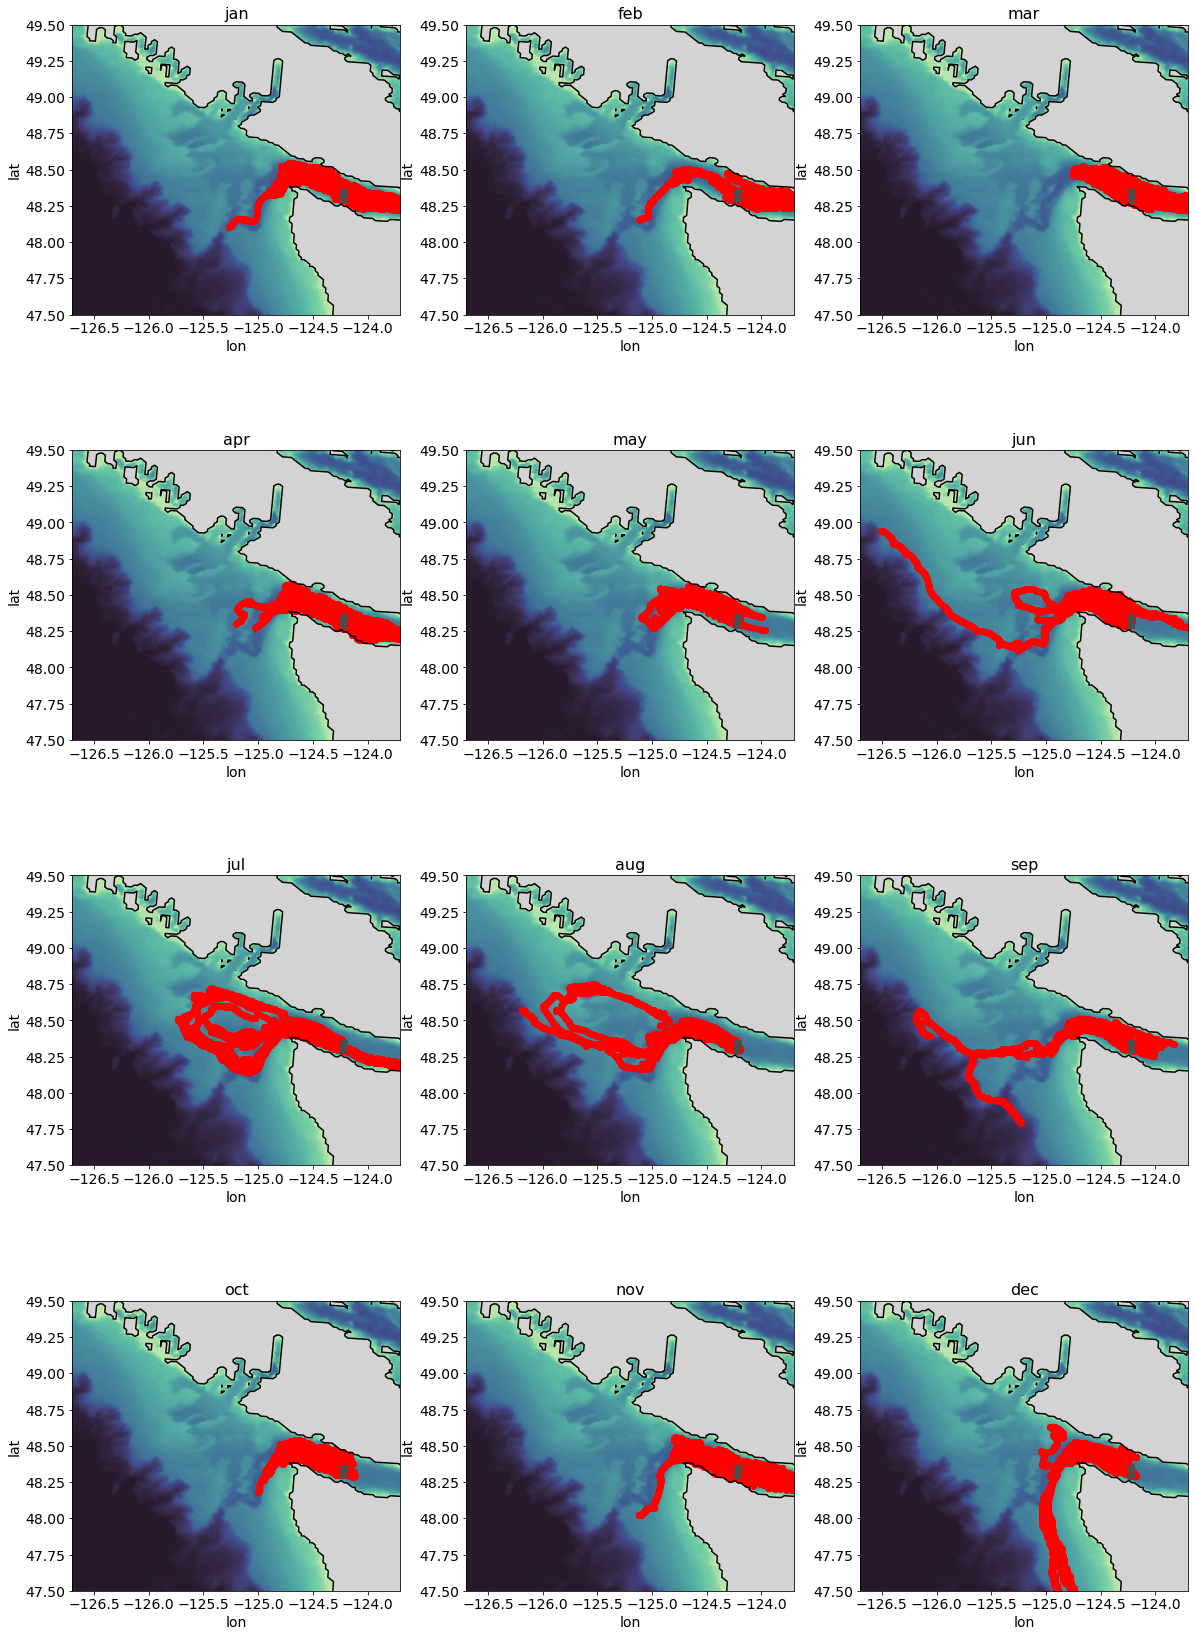

In [26]:
# 2D
fig, ax = plt.subplots(4,3,figsize=(20, 30))

plt_qual_2D('jan', ax[0,0])
plt_qual_2D('feb', ax[0,1])
plt_qual_2D('mar', ax[0,2])
plt_qual_2D('apr', ax[1,0])
plt_qual_2D('may', ax[1,1])
plt_qual_2D('jun', ax[1,2])
plt_qual_2D('jul', ax[2,0])
plt_qual_2D('aug', ax[2,1])
plt_qual_2D('sep', ax[2,2])
plt_qual_2D('oct', ax[3,0])
plt_qual_2D('nov', ax[3,1])
plt_qual_2D('dec', ax[3,2])